In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import operator
import joblib

from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

import xgboost as xgb

In [2]:
X_train = pd.read_csv('data/cleaned_data_train_x.csv', index_col=0)
X_test = pd.read_csv('data/cleaned_data_test_x.csv', index_col=0)

y_train = pd.read_csv('data/cleaned_data_train_y.csv', index_col=0)
y_test = pd.read_csv('data/cleaned_data_test_y.csv', index_col=0)
scaler = joblib.load('min_max_scaler.pkl')

In [3]:
model = svm.SVR()
grid_values = {'gamma': [0.01, 0.03, 0.1, 0.3, 1, 3, 9], 'C': [0.1, 0.3, 1, 3, 9], 'epsilon': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1]}
grid_search = GridSearchCV(model, param_grid=grid_values, n_jobs=-1, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print("MSE score: %f" % mean_squared_error(y_test, grid_search.predict(X_test)))

/home/andrew/anaconda3/envs/college-tuition/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 1, 'epsilon': 0.01, 'gamma': 0.3}
MSE score: 0.004399


In [4]:
model = RandomForestRegressor(n_estimators=1000)
grid_values = {
            'max_features': ['auto', 'sqrt'], 
            'min_samples_leaf': [1, 5, 10, 15],
            'min_samples_split': [2, 5, 10],
            'max_depth': [10, 30, 100, None]
        }
grid_search = GridSearchCV(model, param_grid=grid_values, n_jobs=-1, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print("MSE score: %f" % mean_squared_error(y_test, grid_search.predict(X_test)))

/home/andrew/anaconda3/envs/college-tuition/lib/python3.7/site-packages/sklearn/model_selection/_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
MSE score: 0.003386


In [5]:
params = {
        'learning_rate': [0.03, 0.1, 0.3],
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 1, 5],
        'subsample': [0.4, 0.75, 1.0],
        'max_depth': [5, 9, 15],
    }

clf = xgb.XGBRegressor(n_estimators=1000, objective='reg:squarederror', n_jobs=1)
grid_search = GridSearchCV(clf, param_grid=params, scoring='neg_mean_squared_error', n_jobs=-1, cv=3)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

bst = xgb.XGBRegressor(**grid_search.best_params_, n_estimators=1000, objective='reg:squarederror', n_jobs=-1)
bst.fit(X_train, y_train)

print("MSE score: %f" % mean_squared_error(y_test, bst.predict(X_test)))

feature_importance = bst.get_booster().get_score(importance_type='weight')
feature_importance = sorted(feature_importance.items(), key=operator.itemgetter(1), reverse=True)
print(feature_importance)

{'gamma': 0, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.75}
MSE score: 0.003144
[('Admissions yield', 1439), ('Average professor salary', 1261), ('Graduation rate', 1219), ('Books and supplies 2017-18', 1196), ('Part-time enrollment', 1117), ('Percent admitted', 1095), ('Total library expenditures per FTE', 1074), ('Graduate enrollment', 1005), ('Total dormitory capacity', 1003), ('Black proportion', 959), ('Whie proportion', 880), ('Full-time retention rate', 844), ('Total FTE staff', 839), ('Hispanic/Latino proportion', 764), ('Student-to-faculty ratio', 762), ('Total enrollment', 725), ('Asian proportion', 672), ('Full-time enrollment', 666), ('Undergraduate enrollment', 632), ('Undergraduates in state', 631), ('Undergraduates out of state', 495), ('Undergraduates foreign', 331), ('x0_Private not-for-profit', 327), ('x0_Public', 209), ('x1_Suburb: Large', 95), ('x1_Rural: Fringe', 51), ('x1_City: Small', 51), ('x1_Rural: Distant', 47), ('x1_Suburb: 

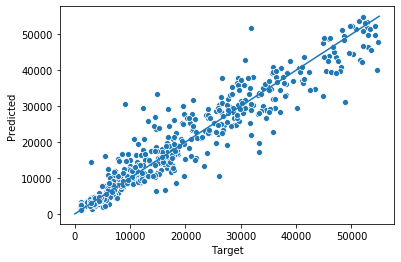

In [6]:
y_test_tfm = scaler.inverse_transform(y_test).reshape(-1, 1).flatten()
pred_y_test_tfm = scaler.inverse_transform(bst.predict(X_test).reshape(-1, 1)).reshape(1, -1)[0]

sns_plot = sns.scatterplot(x=y_test_tfm, y=pred_y_test_tfm)
fig = sns_plot.get_figure()
plt.plot(np.linspace(0,55000,100), np.linspace(0,55000,100))
plt.xlabel('Target')
plt.ylabel('Predicted')
fig.savefig("visualizations/predictions.png")

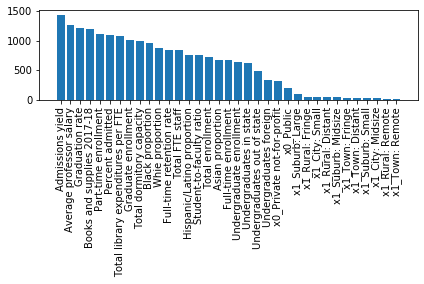

In [9]:
fig = plt.figure()
plt.xticks(rotation='vertical')
plt.bar(*zip(*feature_importance))
plt.tight_layout()
fig.savefig("visualizations/feature_importance.png", dpi=400)
plt.show()

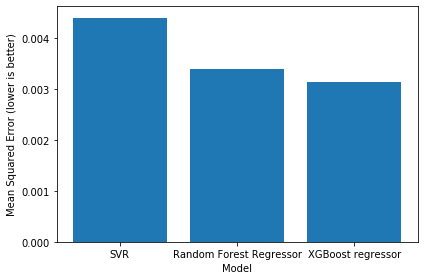

In [4]:
fig = plt.figure()
plt.bar(*zip(*[('SVR', 0.004399), ('Random Forest Regressor', 0.003386), ('XGBoost regressor', 0.003144)]))
plt.xlabel('Model')
plt.ylabel('Mean Squared Error (lower is better)')
plt.tight_layout()
fig.savefig("visualizations/results.png")
plt.show()